In [1]:
# Tutorial source: https://nbviewer.jupyter.org/github/krasserm/face-recognition/blob/master/face-recognition.ipynb?flush_cache=true

In [25]:
import bz2
import os

from urllib.request import urlopen

def download_landmarks(dst_file):
    url = 'http://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2'
    decompressor = bz2.BZ2Decompressor()
    
    with urlopen(url) as src, open(dst_file, 'wb') as dst:
        data = src.read(1024)
        while len(data) > 0:
            dst.write(decompressor.decompress(data))
            data = src.read(1024)

dst_dir = 'models'
dst_file = os.path.join(dst_dir, 'landmarks.dat')

if not os.path.exists(dst_file):
    os.makedirs(dst_dir)
    download_landmarks(dst_file)

In [13]:
from keras.models import load_model
from keras.utils import CustomObjectScope

import tensorflow as tf

In [14]:
from model import create_model


In [16]:
nn4_small2_pretrained = create_model()
nn4_small2_pretrained.load_weights('model/nn4.small2.v1.h5')

In [117]:
import numpy as np
import os.path

class IdentityMetadata():
    def __init__(self, base, file):
        # dataset base directory
        self.base = base
        # image file name
        self.file = file

    def __repr__(self):
        return self.image_path()

    def image_path(self):
        return os.path.join(self.base, self.file) 
    
def load_metadata(path):
    metadata = []
    for f in os.listdir(os.path.join(path)):
        metadata.append(IdentityMetadata(path,  f))
    return np.array(metadata)

metadata = load_metadata('data/faces')

In [118]:
import cv2
import matplotlib.pyplot as plt
import matplotlib.patches as patches

from align import AlignDlib

%matplotlib inline


In [132]:
def load_image(path):
    img = cv2.imread(path, 1)
    if img is None:
        return None
    # OpenCV loads images with color channels
    # in BGR order. So we need to reverse them
    return img[...,::-1]

In [133]:
alignment = AlignDlib('./models/landmarks.dat')

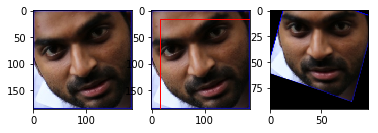

In [138]:
# Load an image of Jacques Chirac
temp_face = load_image(metadata[200].image_path())

# Detect face and return bounding box
bb = alignment.getLargestFaceBoundingBox(temp_face)

# Transform image using specified face landmark indices and crop image to 96x96
temp_face = alignment.align(96, jc_orig, bb, landmarkIndices=AlignDlib.OUTER_EYES_AND_NOSE)


# Show original image
plt.subplot(131)
plt.imshow(jc_orig)

# Show original image with bounding box
plt.subplot(132)
plt.imshow(temp_face)
plt.gca().add_patch(patches.Rectangle((bb.left(), bb.top()), bb.width(), bb.height(), fill=False, color='red'))

# Show aligned image
plt.subplot(133)
plt.imshow(temp_face);

In [154]:
metadata_orig=metadata
metadata = metadata[:100]

In [155]:
def align_image(img):
    return alignment.align(96, img, alignment.getLargestFaceBoundingBox(img), 
                           landmarkIndices=AlignDlib.OUTER_EYES_AND_NOSE)

In [158]:
embedded = np.zeros((metadata.shape[0], 128))

for i, m in enumerate(metadata):
    
    img = load_image(m.image_path())
    if img is None:
        continue
    img = align_image(img)
    
    try:
        # scale RGB values to interval [0,1]
        img = (img / 255.).astype(np.float32)
        embedded[i] = nn4_small2_pretrained.predict(np.expand_dims(img, axis=0))[0]
    except Exception as e:
        print(m.file)
        continue


face_754498.jpg
face_970157.jpg
face_293059.jpg
face_420835.jpg
face_151749.jpg
face_166962.jpg
face_992577.jpg
face_682230.jpg
face_304711.jpg
face_469959.jpg
face_307806.jpg
face_302156.jpg
face_286955.jpg
face_774074.jpg
face_972841.jpg
face_221016.jpg
face_405918.jpg
face_371571.jpg
face_684579.jpg
face_947674.jpg
face_144410.jpg
face_852110.jpg
face_730085.jpg
face_417812.jpg
face_555951.jpg
face_570722.jpg
face_109132.jpg


In [195]:
def distance(emb1, emb2):
    return np.sum(np.square(emb1 - emb2))

def show_pair(idx1, idx2):
    plt.figure(figsize=(8,3))
    plt.suptitle('Distance= {:.2}'.format(distance(embedded[idx1], embedded[idx2]).astype(float)))
    plt.subplot(121)
    plt.imshow(load_image(metadata[idx1].image_path()))
    plt.subplot(122)
    plt.imshow(load_image(metadata[idx2].image_path()));   

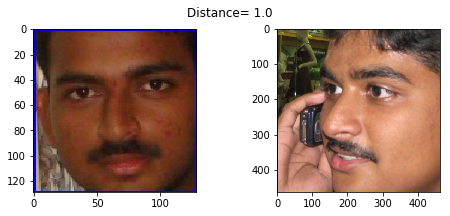

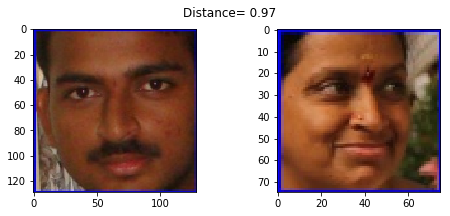

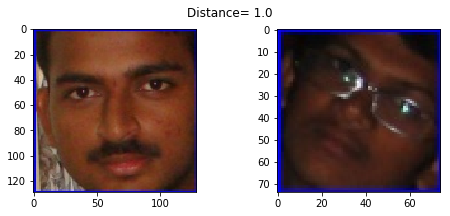

In [196]:
show_pair(3, 29)
show_pair(3, 49)
show_pair(3, 13)

In [143]:
metadata_orig = metadata
embedded_orig = embedded

In [144]:
metadata = metadata[:100]
embedded = embedded[:100]

print(len(metadata), len(embedded))

100 100


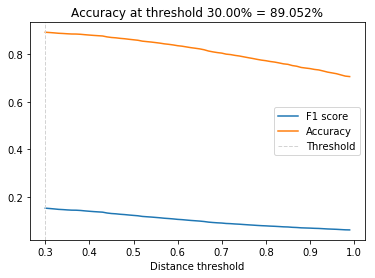

In [145]:
from sklearn.metrics import f1_score, accuracy_score

distances = [] # squared L2 distance between pairs
identical = [] # 1 if same identity, 0 otherwise

num = len(metadata)

for i in range(num - 1):
    for j in range(1, num):
        distances.append(distance(embedded[i], embedded[j]))
        identical.append(1 if metadata[i].file == metadata[j].file else 0)
        
distances = np.array(distances)
identical = np.array(identical)

thresholds = np.arange(0.3, 1.0, 0.01)

f1_scores = [f1_score(identical, distances < t) for t in thresholds]
acc_scores = [accuracy_score(identical, distances < t) for t in thresholds]

opt_idx = np.argmax(f1_scores)
# Threshold at maximal F1 score
opt_tau = thresholds[opt_idx]
# Accuracy at maximal F1 score
opt_acc = accuracy_score(identical, distances < opt_tau)

# Plot F1 score and accuracy as function of distance threshold
plt.plot(thresholds, f1_scores, label='F1 score');
plt.plot(thresholds, acc_scores, label='Accuracy');
plt.axvline(x=opt_tau, linestyle='--', lw=1, c='lightgrey', label='Threshold')
plt.title('Accuracy at threshold {:.2%} = {:.3%}'.format(opt_tau, opt_acc));
plt.xlabel('Distance threshold')
plt.legend();

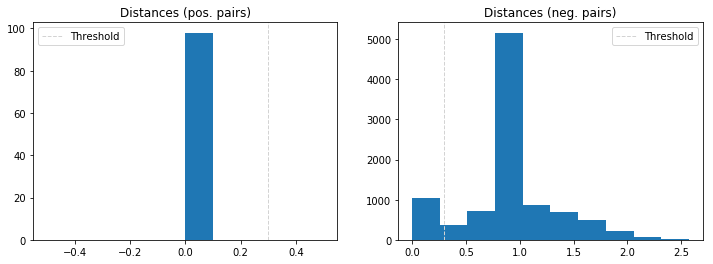

In [146]:
dist_pos = distances[identical == 1]
dist_neg = distances[identical == 0]

plt.figure(figsize=(12,4))

plt.subplot(121)
plt.hist(dist_pos)
plt.axvline(x=opt_tau, linestyle='--', lw=1, c='lightgrey', label='Threshold')
plt.title('Distances (pos. pairs)')
plt.legend();

plt.subplot(122)
plt.hist(dist_neg)
plt.axvline(x=opt_tau, linestyle='--', lw=1, c='lightgrey', label='Threshold')
plt.title('Distances (neg. pairs)')
plt.legend();

In [147]:
np.arange(0.3, 1.0, 0.01)

array([ 0.3 ,  0.31,  0.32,  0.33,  0.34,  0.35,  0.36,  0.37,  0.38,
        0.39,  0.4 ,  0.41,  0.42,  0.43,  0.44,  0.45,  0.46,  0.47,
        0.48,  0.49,  0.5 ,  0.51,  0.52,  0.53,  0.54,  0.55,  0.56,
        0.57,  0.58,  0.59,  0.6 ,  0.61,  0.62,  0.63,  0.64,  0.65,
        0.66,  0.67,  0.68,  0.69,  0.7 ,  0.71,  0.72,  0.73,  0.74,
        0.75,  0.76,  0.77,  0.78,  0.79,  0.8 ,  0.81,  0.82,  0.83,
        0.84,  0.85,  0.86,  0.87,  0.88,  0.89,  0.9 ,  0.91,  0.92,
        0.93,  0.94,  0.95,  0.96,  0.97,  0.98,  0.99])

In [150]:
from sklearn.preprocessing import LabelEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC

targets = np.array([m.file for m in metadata])

encoder = LabelEncoder()
encoder.fit(targets)

# Numerical encoding of identities
y = encoder.transform(targets)

train_idx = np.arange(metadata.shape[0]) % 2 != 0
test_idx = np.arange(metadata.shape[0]) % 2 == 0

# 50 train examples of 10 identities (5 examples each)
X_train = embedded[train_idx]
# 50 test examples of 10 identities (5 examples each)
X_test = embedded[test_idx]

y_train = y[train_idx]
y_test = y[test_idx]

knn = KNeighborsClassifier(n_neighbors=1, metric='euclidean')
svc = LinearSVC()

knn.fit(X_train, y_train)
svc.fit(X_train, y_train)

acc_knn = accuracy_score(y_test, knn.predict(X_test))
acc_svc = accuracy_score(y_test, svc.predict(X_test))

print('KNN accuracy = {0}, SVM accuracy = {1}'.format(acc_knn, acc_svc ))

KNN accuracy = 0.0, SVM accuracy = 0.0


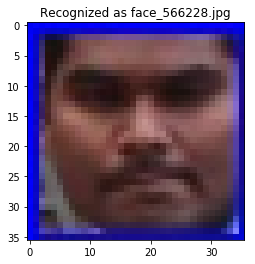

In [151]:
import warnings
# Suppress LabelEncoder warning
warnings.filterwarnings('ignore')

example_idx = 29

example_image = load_image(metadata[test_idx][example_idx].image_path())
example_prediction = svc.predict([embedded[test_idx][example_idx]])
example_identity = encoder.inverse_transform(example_prediction)[0]

plt.imshow(example_image)
plt.title('Recognized as {}'.format(example_identity));

In [152]:
print(test_idx, example_idx)
metadata[test_idx][example_idx].image_path()

[ True False  True False  True False  True False  True False  True False
  True False  True False  True False  True False  True False  True False
  True False  True False  True False  True False  True False  True False
  True False  True False  True False  True False  True False  True False
  True False  True False  True False  True False  True False  True False
  True False  True False  True False  True False  True False  True False
  True False  True False  True False  True False  True False  True False
  True False  True False  True False  True False  True False  True False
  True False  True False] 29


'data/faces/face_898448.jpg'

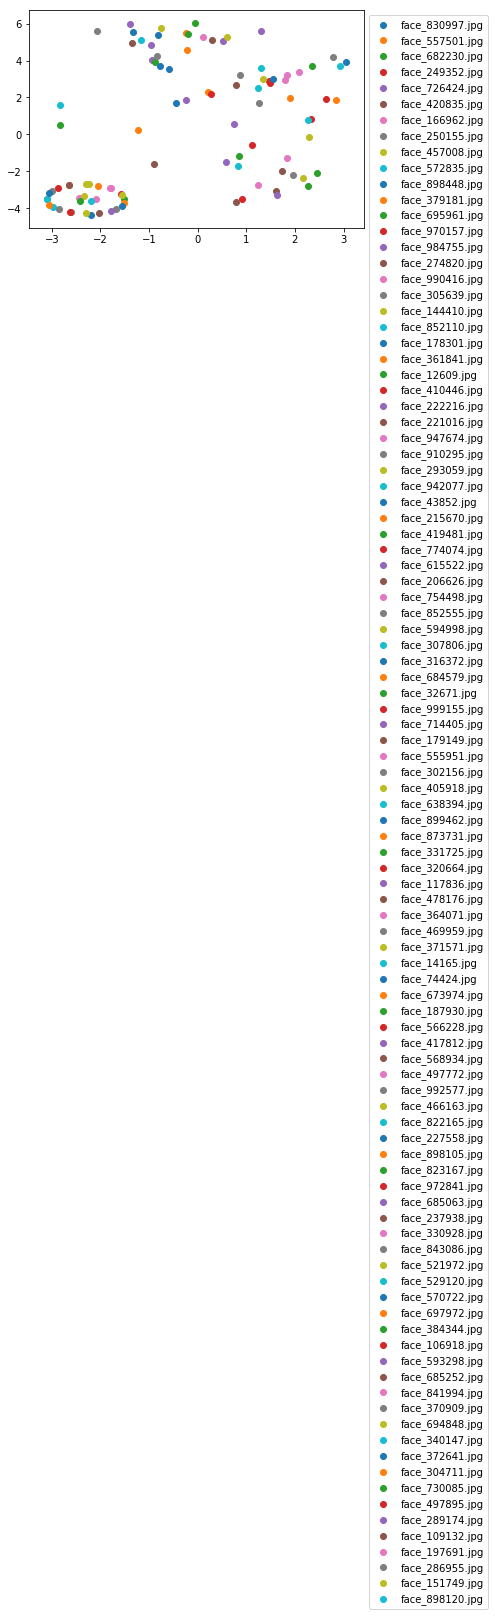

In [153]:
from sklearn.manifold import TSNE

X_embedded = TSNE(n_components=2).fit_transform(embedded)

for i, t in enumerate(set(targets)):
    idx = targets == t
    plt.scatter(X_embedded[idx, 0], X_embedded[idx, 1], label=t)   

plt.legend(bbox_to_anchor=(1, 1));